In [1]:
# Import packages
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1. This exercise analyzes daily S&P 500 data from the beginning of 2010 to the most recent trading date. The dataset is divided into two subsamples. First sub sample: Covers data from the beginning of 2010 to the end of 2018. Second subsample: Includes data from the beginning of 2019 to the most recent trading date.

In [2]:
# First subsample
sp1 = yf.download('^SPX', start='2010-01-01', end='2018-12-31', interval='1d', auto_adjust=False)
sp1=sp1.reset_index()
# Second subsample
sp2 = yf.download('^SPX', start='2019-01-01', end='2025-01-24', interval='1d', auto_adjust=False)
sp2=sp2.reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### (a) Estimate the mean and variance of the daily log returns of the S&P 500 using the first subsample.

In [3]:
log_return_sp1 = pd.DataFrame() # Create an empty data frame
log_return_sp1['Adj Close'] = np.log(sp1['Adj Close'] / sp1['Adj Close'].shift(1)) # Create log returns column
log_return_sp1['Date'] = sp1['Date']
log_return_sp1 = log_return_sp1.dropna().reset_index(drop=True)

log_return_sp2 = pd.DataFrame() # Create an empty data frame
log_return_sp2['Adj Close'] = np.log(sp2['Adj Close'] / sp2['Adj Close'].shift(1)) # Create log returns column
log_return_sp2['Date'] = sp2['Date']
log_return_sp2 = log_return_sp2.dropna().reset_index(drop=True)

print('Mean:', log_return_sp1['Adj Close'].mean())
print('Variance:', log_return_sp1['Adj Close'].var())

Mean: 0.0003473520118250819
Variance: 8.958401466705501e-05


### (b) Generate a normal random walk $\{s_t\}^T_{t=1}$: $s_t = s_{t-1} + \varepsilon_t$ where $\varepsilon_t$ ~ iid $N(\mu, \sigma^2)$ and set the random seed to 432. Replace $T$ with the sample size of the second subsample, and use the estimated $\mu$ and $\sigma^2$ from part (a). Plot the simulated random walk alongside the log S&P 500, denoted as $p_t$. Comment on your findings.

In [4]:
# Log price of S&P 500
log_sp1 = pd.DataFrame()
log_sp1['Adj Close'] = np.log(sp1['Adj Close'])
log_sp1['Date'] = sp1['Date']

log_sp2 = pd.DataFrame()
log_sp2['Adj Close'] = np.log(sp2['Adj Close'])
log_sp2['Date'] = sp2['Date']

In [5]:
np.random.seed(432) # Set random seed

# T
T = len(log_sp2)

# Mean and variance from log returns
mu = log_return_sp1['Adj Close'].mean()
sigma = log_return_sp1['Adj Close'].std()

# Create epsilon
epsilon = np.random.normal(loc = mu, scale = sigma, size = T)

s_t = np.zeros(T) # Create s_t

# Set first value of the random walk equal to the first value of the log price
s_t[0] = log_sp2['Adj Close'].iloc[0]
for t in range(1, T):
    s_t[t] = s_t[t-1] + epsilon[t] # Random walk

s_t = pd.DataFrame(s_t)

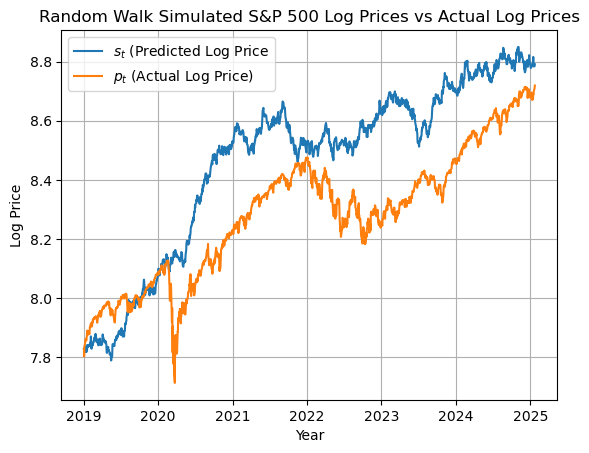

In [6]:
# Plot simulated random walk vs actual log prices
plt.plot(log_sp2['Date'], s_t, label = f'$s_t$ (Predicted Log Price') # Random walk simulated log price
plt.plot(log_sp2['Date'], log_sp2['Adj Close'], label = f'$p_t$ (Actual Log Price)') # Actual log price
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) # Only show the year on the x axis
plt.xlabel('Year')
plt.ylabel('Log Price')
plt.title('Random Walk Simulated S&P 500 Log Prices vs Actual Log Prices')
plt.legend()
plt.grid()

The simulated random walk seems to have a similar overall trend as the actual log prices, but overestimates them. There is significant deviation in 2020 which is to be expected because of the COVID-19 pandemic.

### (c) Run the following linear regression using the second subsample and the simulated random walk from part (b):
### $$p_t = \alpha + s_t\beta + u_t$$
### Report the t-ratio for the estimator of $\beta$. Does the result suggest that a computer generated random walk can predict the stock market?

In [7]:
# Regressing actual log prices on predicted log prices
X = sm.add_constant(s_t)
model = sm.OLS(log_sp2['Adj Close'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     6234.
Date:                Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:02:24   Log-Likelihood:                 1391.4
No. Observations:                1524   AIC:                            -2779.
Df Residuals:                    1522   BIC:                            -2768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6100      0.072     36.301      0.0

The regression shows that the simulated random walk explains a decent amount of the variation in actual log S&P 500 prices, having a R-squared value of 0.804. The coefficient of about 0.67 is highly statistically significant with a t-statistic of about 80. These factors do not mean that a computer generated random can predict the stock market, but it does capture the overall trends and directions in the market.

## 2. This exercise utilizes daily data of Apple (AAPL) from the beginning of January 2010 to the most recent trade date. Adjusted closing prices are used to compute daily log returns.

In [8]:
# Download AAPL prices
aapl = yf.download('AAPL', start = '2010-01-10', end = '2025-03-04', auto_adjust = False)
aapl=aapl.reset_index()

# Create df for AAPL log returns
log_return_aapl = pd.DataFrame()
log_return_aapl['Adj Close'] = pd.DataFrame(np.log(aapl['Adj Close'] / aapl['Adj Close'].shift(1)))
log_return_aapl['Date'] = aapl['Date']

# Drop NAs
log_return_aapl = log_return_aapl.dropna()

log_return_aapl.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Date
1,-0.011440,2010-01-12
2,0.014007,2010-01-13
3,-0.005808,2010-01-14
4,-0.016854,2010-01-15
5,0.043288,2010-01-19


### (a) Using the sample autocorrelation function (ACF) with a maximum lag of 10, assess whether the log returns exhibit white noise characteristics. Perform the Ljung-Boxtest (with lag=10) and interpret the results.

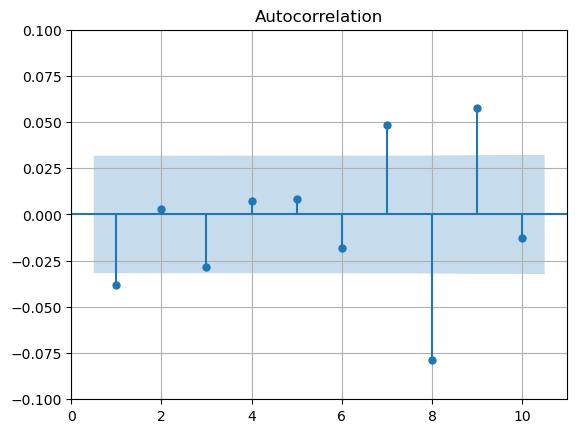

In [9]:
# Create lags from 0 to 10
lags = np.linspace(1, 10, 10)

# ACF plot
fig, ax = plt.subplots()
plot_acf(log_return_aapl['Adj Close'], lags = lags, ax=ax)
ax.set_ylim([-0.1, 0.1])
plt.grid()
plt.show()

The ACF plot shows that AAPL log returns exhibit white noise characteristics at some points, but not when the lag equals 1, 3, 8, and 9.

In [10]:
sm.stats.acorr_ljungbox(log_return_aapl['Adj Close'], lags=lags)

,lb_stat,lb_pvalue
1,5.496455,1.905506e-02
2,5.533407,6.286891e-02
3,8.644897,3.440444e-02
4,8.854982,6.482823e-02
5,9.132018,1.039129e-01
6,10.366105,1.100573e-01
7,19.253223,7.430025e-03
8,42.968637,8.904561e-07
9,55.661972,9.107108e-09
10,56.305412,1.799447e-08


The ACF indicated that Apple’s log returns resemble white noise at lag 10. However, the Ljung–Box test at lag 10 yielded a p-value < 0.05, suggesting that while the individual autocorrelation is small, the joint effect up to lag 10 is statistically significant. This implies weak but detectable autocorrelation structure that is not obvious from the ACF alone. All other lags are consistent between the ACF and Ljung-Box test.

### (b) Determine the optimal lag $p_{opt}$ using AIC for modeling log returns with an AR(p) process. Estimate the AR($p_{opt}$) model using the data and report the results.

In [11]:
aic_val = [] # Create empty list for AIC values at different p-values

# For loop to test different p-values
for p in range(11):
    model = ARIMA(log_return_aapl['Adj Close'], order=(p, 0, 0)).fit()
    aic_val.append(model.aic)

Text(0.5, 1.0, 'Lag Selection for AR(p) by AIC')

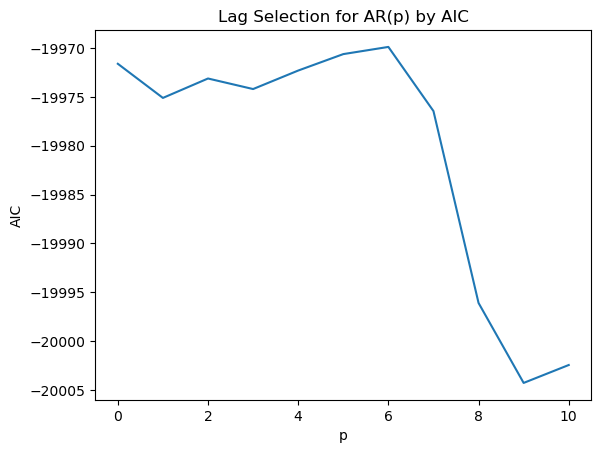

In [12]:
# Plot AIC at different p-values
plt.plot(aic_val)
plt.xlabel('p')
plt.ylabel('AIC')
plt.title('Lag Selection for AR(p) by AIC')

From the graph of AIC at different p-values we can see that a p-value of 9 produces the lowest AIC.

In [13]:
# ARIMA model where p=9
model = ARIMA(log_return_aapl['Adj Close'], order=(9, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3808
Model:                 ARIMA(9, 0, 0)   Log Likelihood               10013.148
Date:                Mon, 29 Sep 2025   AIC                         -20004.296
Time:                        21:02:40   BIC                         -19935.603
Sample:                             0   HQIC                        -19979.885
                               - 3808                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.250      0.001       0.000       0.002
ar.L1         -0.0281      0.012     -2.317      0.021      -0.052      -0.004
ar.L2         -0.0024      0.012     -0.203      0.8

The model shows that lags 1, 3, 7, 8, and 9 are significant at the 5% level. This suggests that there may be short-term predictability in returns

### (c) Determine the optimal lag $q_{opt}$ using AIC for modeling log returns with an MA(q) process. Estimate the MA($q_{opt}$) model using the data and report the results.

In [14]:
aic_val = [] # Create an empty list

# For loop to test for the optimal q value
for q in range(11):
    model = ARIMA(log_return_aapl['Adj Close'], order=(0, 0, q)).fit()
    aic_val.append(model.aic)

Text(0.5, 1.0, 'Lag Selection for MA(q) by AIC')

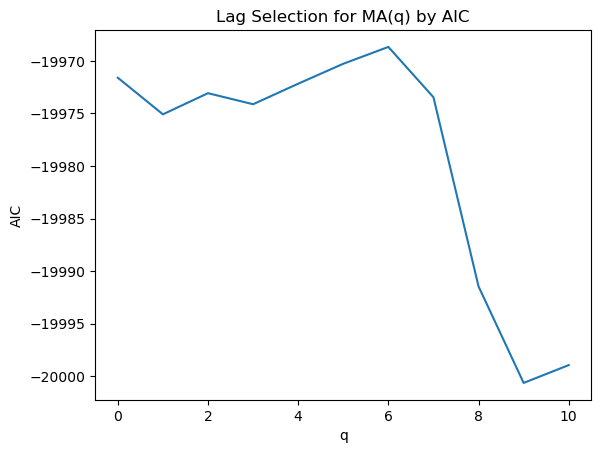

In [15]:
# Plot AIC at different q values
plt.plot(aic_val)
plt.xlabel('q')
plt.ylabel('AIC')
plt.title('Lag Selection for MA(q) by AIC')

The graph of AIC at different q-values shows that the optimal q-value is 9, the same as the optimal p-value.

In [16]:
# ARIMA model where q=9
model = ARIMA(log_return_aapl['Adj Close'], order=(0, 0, 9)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3808
Model:                 ARIMA(0, 0, 9)   Log Likelihood               10011.322
Date:                Mon, 29 Sep 2025   AIC                         -20000.644
Time:                        21:02:56   BIC                         -19931.950
Sample:                             0   HQIC                        -19976.233
                               - 3808                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.244      0.001       0.000       0.002
ma.L1         -0.0286      0.012     -2.334      0.020      -0.053      -0.005
ma.L2         -0.0006      0.012     -0.046      0.9

The model shows that lags 1, 7, 8, and 9 are significant at the 5% level. This is very similar to the results from the model in part (b)

### (d) Identify the optimal lags $p_{opt}$ and $q_{opt}$ using AIC for an ARMA(p,q) model of log returns. Estimate the ARMA($p_{opt}$, $q_{opt}$) model and report the results.

In [17]:
def order_maker(max_p, max_q):

    # Create array of p values repeated for each q
    A     = np.array(range(0,max_p+1))
    A     = (np.kron(A, np.ones((1,max_q+1)))).ravel()

     # Create array of q values repeated for each p
    B     = np.array(range(0,max_q+1))
    B     = (np.kron(np.ones((1,max_p+1)), B)).ravel()

    # d is fixed at 0 for all combinations
    dim   = np.size(A)
    D     = np.zeros(dim)

    # Return all (p, d, q) combinations
    return (np.array([A, D, B])).T

def Est_ARIMA(data, order):

    max_ord = len(order) # Number of candidate models
    
    score = np.zeros(max_ord) # Store AIC scores for each model

    n = len(data)
    resid = np.zeros((n,max_ord)) # Store residuals for each model (n x max_ord)

    col = [None]*max_ord # Placeholder for residual column names
    
    resid_ind = data.index[:]  # Save the index from the input data

    for p in range(0,max_ord):
        order_p = order[p,:] # Get (p,d,q)
        method = ARIMA(data, order = order_p) # Initialize model
        est_rslt = method.fit() # Fit model
        score[p] = est_rslt.aic # Save AIC
        resid[:,p] = est_rslt.resid # Save residuals
        col[p] = f'ARMA{order_p}' # Label column

    # Pick the order with lowest AIC
    ord_ind = np.argmin(score); 
    ord_sel = order[ord_ind,:]

    # Convert residuals into DataFrame
    resid   = pd.DataFrame(data = resid, index = resid_ind, columns = col)

    return ord_sel, score, resid

In [18]:
order = order_maker(5, 5)
order_sel = Est_ARIMA(log_return_aapl['Adj Close'], order)[0]
result = ARIMA(log_return_aapl['Adj Close'], order=order_sel).fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3808
Model:                 ARIMA(5, 0, 4)   Log Likelihood               10008.916
Date:                Mon, 29 Sep 2025   AIC                         -19995.832
Time:                        21:04:16   BIC                         -19927.138
Sample:                             0   HQIC                        -19971.421
                               - 3808                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.267      0.001       0.000       0.002
ar.L1         -0.9956      1.086     -0.917      0.359      -3.123       1.132
ar.L2          0.1180      1.854      0.064      0.9

In [19]:
order_sel

array([5., 0., 4.])

The optimal ARMA model is ARMA(5, 4) where $p_{opt}=5$ and $q_{opt}=4$. However, none of the coefficients are statistically significant, meaning it does not capture much predictability.

### (e) Plot the fitted residuals from the ARMA($p_{opt}$, $q_{opt}$) model estimated in part (d). Based on the visual analysis, assess whether ARMA($p_{opt}$, $q_{opt}$) is an appropriate model for log returns.

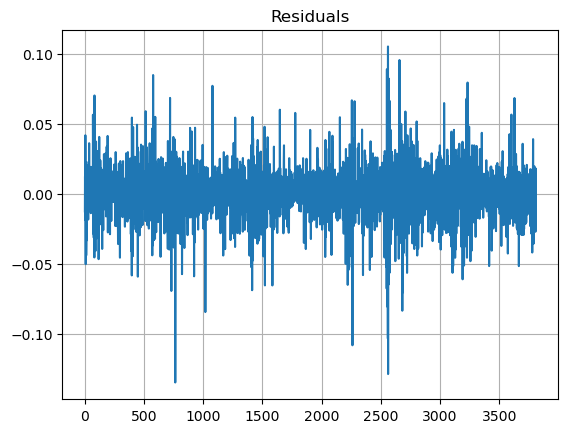

In [20]:
# Plot the residuals
plt.plot(result.resid)
plt.title('Residuals')
plt.grid()

The residuals seem to fluctuate around zero and have no obvious trends which is good, however the variance does not seem to be constant.

### (f) From the beginning of 2024, use a rolling window of one year of data to estimate AR(1), MA(1), and ARMA(1,1) models. Utilize the estimated models to generate one-period-ahead forecasts. Evaluate and compare the out-of sample forecasting accuracy of these models.

In [21]:
df = log_return_aapl.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) # Set the date as the index

window_size = 252 # 252 trading days in a year

errors = {'AR(1)': [], 'MA(1)': [], 'ARMA(1,1)': []} # list of models and respective MSE
dates = []

In [22]:
start_date = '2024-01-01'

# Find index where 2024 begins
start_idx = df.index.searchsorted(start_date)

# Rolling window forecasting
for i in range(start_idx - window_size, len(df) - window_size):
    train = df['Adj Close'].iloc[i:i + window_size].copy()  
    train = train.asfreq('B')
    test = df['Adj Close'].iloc[i + window_size]

    # Fit AR(1)
    ar_model = ARIMA(train, order=(1,0,0)).fit()
    ar_forecast = ar_model.forecast(steps=1).iloc[0]

    # Fit MA(1)
    ma_model = ARIMA(train, order=(0,0,1)).fit()
    ma_forecast = ma_model.forecast(steps=1).iloc[0]

    # Fit ARMA(1,1)
    arma_model = ARIMA(train, order=(1,0,1)).fit()
    arma_forecast = arma_model.forecast(steps=1).iloc[0]
    
    # Store errors
    errors['AR(1)'].append((ar_forecast - test) ** 2)
    errors['MA(1)'].append((ma_forecast - test) ** 2)
    errors['ARMA(1,1)'].append((arma_forecast - test) ** 2)
    dates.append(df.index[i + window_size])

In [23]:
# Store results
mse_results = {model: np.mean(errors[model]) for model in errors}

print("Mean Squared Errors:")
print(mse_results)

Mean Squared Errors:
{'AR(1)': 0.00021968737729475098, 'MA(1)': 0.00021915922223131275, 'ARMA(1,1)': 0.00022047434287563133}
